In [2]:
%matplotlib inline

import sys
import os
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib
from matplotlib import pyplot as plt, animation, rc,colors
from datetime import datetime, timedelta
from cartopy import crs, feature
import cmocean
import yaml

from IPython.display import Image
rc('animation', html='html5')

sys.path.append('/home/jvalenti/MOAD/analysis-jose/Source')
from OP_functions import *

In [3]:
conc=xr.open_dataarray('/home/jvalenti/MOAD/results/Fraser_biof_prob.nc')
conc1=xr.open_dataarray('/home/jvalenti/MOAD/results/Fraser_nobiof_prob.nc')
conc2=xr.open_dataarray('/home/jvalenti/MOAD/results/Turb_off_prob.nc')
conc3=xr.open_dataarray('/home/jvalenti/MOAD/results/No_float_prob.nc')
conc4=xr.open_dataarray('/home/jvalenti/MOAD/results/No_float-noturb_prob.nc')

local = 0 #Set to 0 when working on server
paths = path(local)
coords = xr.open_dataset(paths['coords'], decode_times=False)
mask = xr.open_dataset(paths['mask'])
Dat=xr.open_dataset(paths['coords'],decode_times=False)
outf_lat=Dat['nav_lat'][445,304]
outf_lon=Dat['nav_lon'][445,304]
clon, clat = [float(outf_lon)],[float(outf_lat)]

In [4]:
def mapanimation(file,clon,clat,fps=1,local=1):
    
    def update(frame): 
        plt.clf()
        ax = plt.axes(xlim=(-125,-122.5),ylim=(48.5,49.7))
        t = ax.text(0.02, 0.02, '', transform=ax.transAxes)
        t.set_text('')
        tstamp = file.time[frame].values.astype('datetime64[s]').astype(datetime)
        #print(tstamp)
        t.set_text(tstamp)
        ss = []
        ss.append(ax.contourf(coords.nav_lon, coords.nav_lat, file[frame,:,:],levels=np.arange(1,30,2),cmap=cmocean.cm.dense))
        ax.contour(coords.nav_lon, coords.nav_lat, mask.mbathy[0,:,:],colors='k',linewidths=0.1)
        ax.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
        ax.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
        ax.grid()
        axs.set_aspect(1/np.sin(np.deg2rad(49)))
        plt.ylabel('Latitude',fontsize=16)
        plt.xlabel('Longitude',fontsize=16)
        return fig
        
    #scatter_particles(ax, N,n, 0,0, ds.lat,ds.lon)
    #sed= {0: "w", 1: "k"}


    return animation.FuncAnimation(fig, update, frames=np.arange(0,file.shape[0],fps))

In [5]:
z = mask.gdepw_0[0,:,240,340]
# cend=conc*0.1*(2118/5)*(2*3600/2.6e6)
# cend1=conc1*0.1*(2118/5)*(2*3600/2.6e6)
# cend2=conc2*0.1*(2118/5)*(2*3600/2.6e6)
# cend3=conc3*0.1*(2118/5)*(2*3600/2.6e6)


# fig = plt.figure(figsize=(19, 8))
# axs = plt.axes(xlim=(-123.25,-122.8),ylim=(49,49.25))
# #axs=plt.axes(xlim=(-125,-122.5),ylim=(48.5,49.7))

# levels = np.linspace(1,800,50)

# colors = list(cmocean.cm.dense(np.linspace(0,1,len(levels)-1)))
# colors[-1] = "red"
# cmap = matplotlib.colors.ListedColormap(colors,"", len(colors))



# #axs.contourf(coords.nav_lon, coords.nav_lat, 10*mask.mbathy[0,:,:],levels=np.arange(0,400,10),cmap=cmocean.cm.deep,alpha=1)
# a=axs.contourf(coords.nav_lon, coords.nav_lat, cend2[:,:,0],levels=np.arange(1,150,5),cmap=cmap,extend='max')
# #axs.scatter(frs_lon,frs_lat)
# axs.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')

# #axs.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
# plt.colorbar(a)

# axs.set_aspect(1/np.sin(np.deg2rad(49)))

In [6]:
vol=xr.open_dataset('/home/jvalenti/MOAD/grid/grid/mesh_maskBV201702.nc')['volume_cell']

In [7]:
def get_conc(latmin,latmax,lonmin,lonmax, conc):
    jjii = xr.open_dataset('~/MOAD/grid/grid/grid_from_lat_lon_mask999.nc')
    j = [jjii.jj.sel(lats=latmin, lons=lonmin, method='nearest').item()]
    i = [jjii.ii.sel(lats=latmin, lons=lonmin, method='nearest').item()]
    j.append(jjii.jj.sel(lats=latmin, lons=lonmax, method='nearest').item())
    i.append(jjii.ii.sel(lats=latmin, lons=lonmax, method='nearest').item())
    j.append(jjii.jj.sel(lats=latmax, lons=lonmin, method='nearest').item())
    i.append(jjii.ii.sel(lats=latmax, lons=lonmin, method='nearest').item())
    j.append(jjii.jj.sel(lats=latmax, lons=lonmax, method='nearest').item())
    i.append(jjii.ii.sel(lats=latmax, lons=lonmax, method='nearest').item())
    a=[min(j),max(j),min(i),max(i)]
    Len = (a[1]-a[0])*(a[3]-a[2])
    SD = []
    Mean = []
    for ki in range(len(z)):
        values = []
        vols = []
        for j in range(a[0],a[1],1):
            for i in range(a[2],a[3],1):
                values.append(conc[j,i,ki])
                vols.append(vol[0,ki,j,i])
        values = np.array(values)
        vols = np.array(vols)
        Mean.append(np.sum(values)/np.sum(vols))
        valuess = np.divide(values,vols)
        SD.append(np.std(valuess)/np.sqrt(Len))
    return Mean,SD

In [8]:
def get_area(latmin,latmax,lonmin,lonmax, conc):
    jjii = xr.open_dataset('~/MOAD/grid/grid/grid_from_lat_lon_mask999.nc')
    j = [jjii.jj.sel(lats=latmin, lons=lonmin, method='nearest').item()]
    i = [jjii.ii.sel(lats=latmin, lons=lonmin, method='nearest').item()]
    j.append(jjii.jj.sel(lats=latmin, lons=lonmax, method='nearest').item())
    i.append(jjii.ii.sel(lats=latmin, lons=lonmax, method='nearest').item())
    j.append(jjii.jj.sel(lats=latmax, lons=lonmin, method='nearest').item())
    i.append(jjii.ii.sel(lats=latmax, lons=lonmin, method='nearest').item())
    j.append(jjii.jj.sel(lats=latmax, lons=lonmax, method='nearest').item())
    i.append(jjii.ii.sel(lats=latmax, lons=lonmax, method='nearest').item())
    a=[min(j),max(j),min(i),max(i)]
    Len = (a[1]-a[0])*(a[3]-a[2])
    SD = []
    Mean = []
    for ki in range(len(z)):
        values = []
        for j in range(a[0],a[1],1):
            for i in range(a[2],a[3],1):
                values.append(conc[j,i,ki])
        values = np.array(values)
        Mean.append(np.mean(values))
        #print(Mean)
        SD.append(np.std(values)/np.sqrt(Len))
        #print(SD)
    return Mean,SD

In [40]:
def MP_measur(ax,RES):
    Fraser_MP = RES.iloc[:,[1,7,13,19,25]]
    Fraser_SE = RES.iloc[:,[2,8,14,20,26]]
    Lori_MP = RES.iloc[:,[3,9,15,21,27]]
    Lori_SE = RES.iloc[:,[4,10,16,22,28]]
    SoG_MP = RES.iloc[:,[5,11,17,23,29]]
    SoG_SE = RES.iloc[:,[6,12,18,24,30]]
    label = ['All kernels + 30% floating','No biofouling + 30% floating','No turbulent mixing + 30% floating','No floating','No floating no turbulent mixing']
    for i in range(5):
        ax[1].errorbar(Lori_MP.iloc[:,i], -z, xerr = Lori_SE.iloc[:,i],label=label[i])
        ax[0].errorbar(Fraser_MP.iloc[:,i], -z, xerr = Fraser_SE.iloc[:,i],label=label[i])
        ax[2].errorbar(SoG_MP.iloc[:,i], -z, xerr = SoG_SE.iloc[:,i],label=label[i])
    ax[0].legend()
    ax[1].legend()
    ax[2].legend()
    ax[0].set_ylim(-20,0)
    ax[1].set_ylim(-20,0)
    ax[2].set_ylim(-20,0)
    return 

Text(0.5, 1.0, 'MP concentration in the SoG')

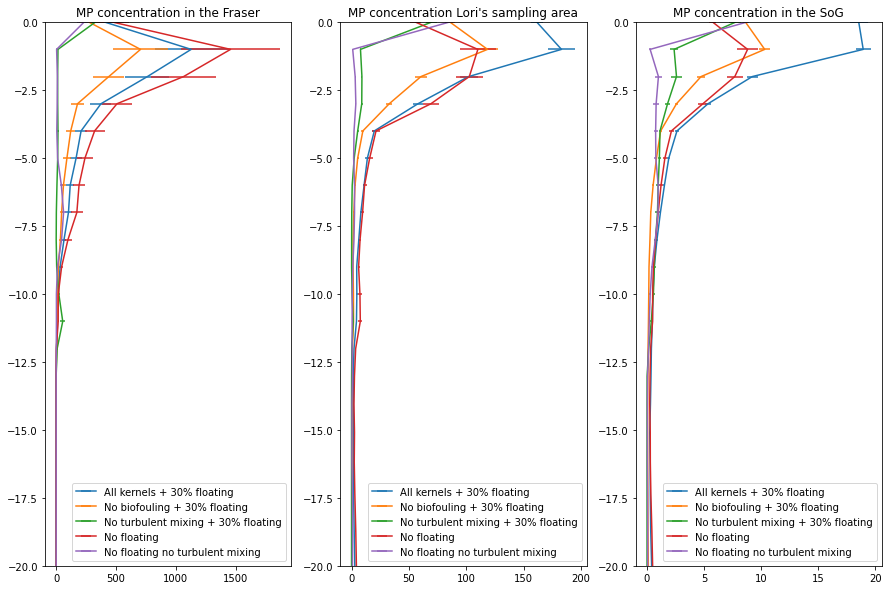

In [10]:
RES = pd.read_csv('results.csv')
fig,axs=plt.subplots(1,3,figsize=(15,10))
MP_measur(axs,RES)
axs[0].set_title('MP concentration in the Fraser')
axs[1].set_title("MP concentration Lori's sampling area")
axs[2].set_title('MP concentration in the SoG')


In [44]:
def MP_measure(ax,conc,label):
    Fraser_MP,Fraser_SE=get_conc(49.1,49.13,-123.2,-123.16,conc)
    SoG_MP,SoG_SE =get_conc(49.2,49.3,-123.5,-123.7,conc)
    Lori_MP,Lori_SE =get_conc(49.1,49.36,-123.3,-123.2,conc)
    ax[1].errorbar(Lori_MP, -z, xerr = Lori_SE,label=label)
    ax[0].errorbar(Fraser_MP, -z, xerr = Fraser_SE,label=label)
    ax[2].errorbar(SoG_MP, -z, xerr = SoG_SE,label=label)
    ax[0].legend()
    ax[1].legend()
    ax[2].legend()
    ax[0].set_ylim(-20,0)
    ax[1].set_ylim(-20,0)
    ax[2].set_ylim(-20,0)
    return Fraser_MP,Fraser_SE, Lori_MP,Lori_SE,SoG_MP,SoG_SE

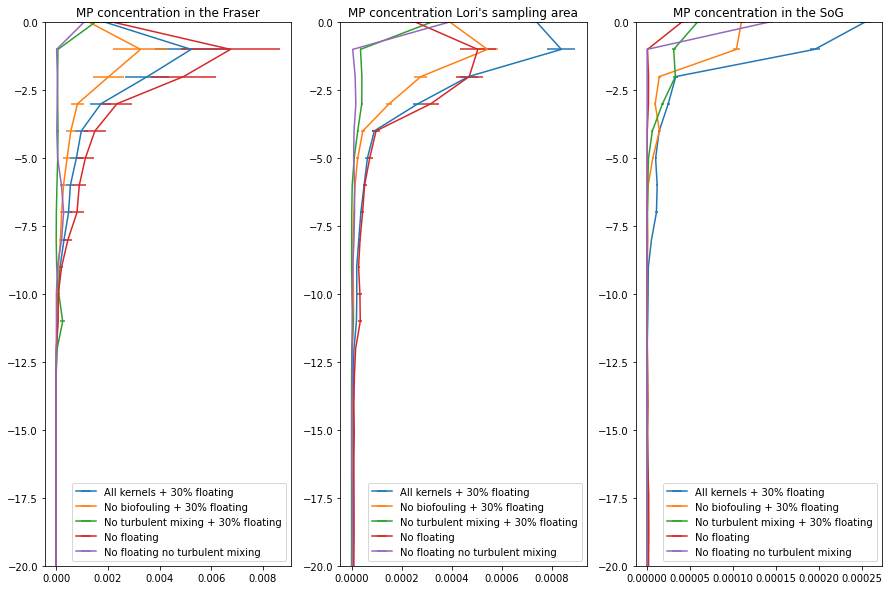

In [45]:
fig,axs=plt.subplots(1,3,figsize=(15,10))
label = ['All kernels + 30% floating','No biofouling + 30% floating','No turbulent mixing + 30% floating','No floating','No floating no turbulent mixing']

F1,FE1,L1,LE1,S1,SE1=MP_measure(axs,conc,label[0])
F2,FE2,L2,LE2,S2,SE2=MP_measure(axs,conc1,label[1])
F3,FE3,L3,LE3,S3,SE3=MP_measure(axs,conc2,label[2])
F4,FE4,L4,LE4,S4,SE4=MP_measure(axs,conc3,label[3])
F5,FE5,L5,LE5,S5,SE5=MP_measure(axs,conc4,label[4])
axs[0].set_title('MP concentration in the Fraser')
axs[1].set_title("MP concentration Lori's sampling area")
axs[2].set_title('MP concentration in the SoG')
dict = {'F1':F1,'FE1':FE1,'L1':L1,'LE1':LE1,'S1':S1,'SE1':SE1,'F2':F2,'FE2':FE2,'L2':L2,'LE2':LE2,'S2':S2,'SE2':SE2,'F3':F3,'FE3':FE3,'L3':L3,'LE3':LE3,'S3':S3,'SE3':SE3,'F4':F4,'FE4':FE4,'L4':L4,'LE4':LE4,'S4':S4,'SE4':SE4,'F5':F5,'FE5':FE5,'L5':L5,'LE5':LE5,'S5':S5,'SE5':SE5}
df = pd.DataFrame(dict) 
df.to_csv('resultsn2.csv')

Text(0.5, 1.0, 'MP concentration in the SoG')

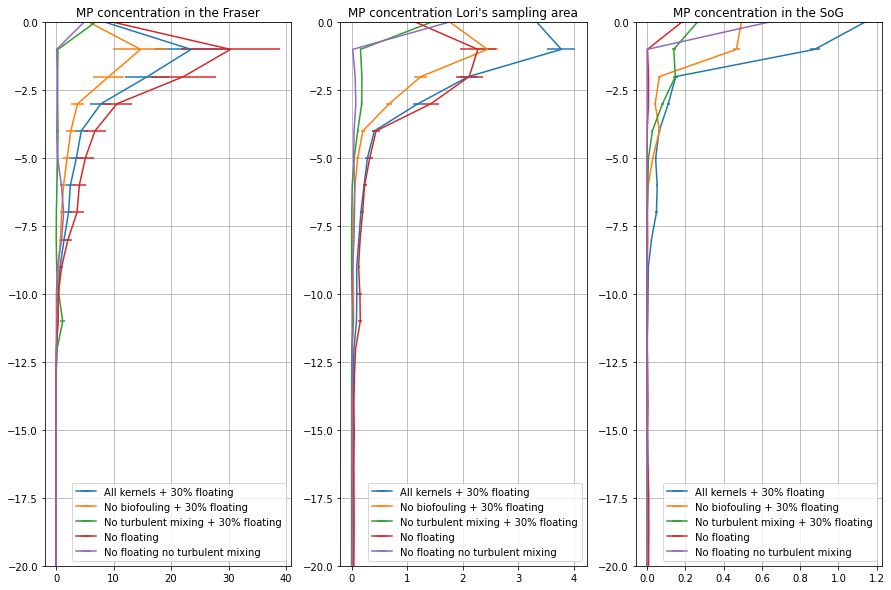

In [46]:
RES = pd.read_csv('resultsn2.csv')*4500
fig,axs=plt.subplots(1,3,figsize=(15,10))
MP_measur(axs,RES)
axs[0].set_title('MP concentration in the Fraser')
axs[1].set_title("MP concentration Lori's sampling area")
axs[0].grid()
axs[1].grid()
axs[2].grid()
axs[2].set_title('MP concentration in the SoG')

Text(0.5, 1.0, 'MP concentration in the SoG')

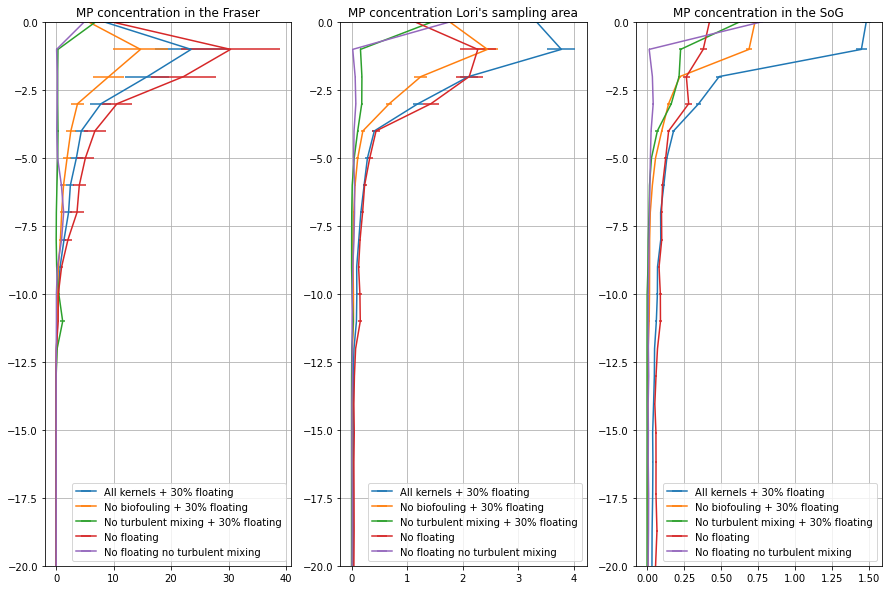

In [43]:
RES = pd.read_csv('resultsn.csv')*4500
fig,axs=plt.subplots(1,3,figsize=(15,10))
MP_measur(axs,RES)
axs[0].set_title('MP concentration in the Fraser')
axs[1].set_title("MP concentration Lori's sampling area")
axs[0].grid()
axs[1].grid()
axs[2].grid()
axs[2].set_title('MP concentration in the SoG')

In [ ]:
# dW = np.random.normalvariate(0, sqrt(particle.dt)) 
# wprime = Kzdz + (sqrt(2*Kz)*dW)/particle.dt 
# dzp = wprime*particle.dt

In [ ]:
# fig = plt.figure(figsize=(19, 8))
# anim = mapanimation(conc,clon,clat,fps=1)
# f = r"/home/jvalenti/MOAD/animations/Fraser2.gif" 
# FFwriter = animation.FFMpegWriter()
# anim.save(f, writer = FFwriter)

In [ ]:
#  with open(f,'rb') as anim:
#     display(Image(anim.read()))